In [180]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, pylab as pl 
libPath = 'project1/scripts'
import sys
if not libPath in sys.path: sys.path.append(libPath)
from implementations import *
from proj1_helpers import *

# 1. Choosing a model

Simple linear model:
$y = w_1x_1+\dots + w_nx_n$

In [181]:
feature_cols = [1, 3, 4, 8, 10, 11, 12, 13, 22]
N_VALID_FEATURES = len(feature_cols)

In [191]:
y, inputs, ids = load_csv_data("full_train_data.csv", True)
print(y.shape)
print(inputs.shape)
print(ids.shape)
y

(5000,)
(5000, 30)
(5000,)


array([ 1., -1., -1., ...,  1., -1.,  1.])

In [183]:
inputs_m = np.mean(inputs,0)
inputs_st = np.std(inputs,0)

inputs = (inputs - inputs_m)/inputs_st
print(inputs.shape)


(5000, 30)


In [184]:
print("Mean: ", np.mean(inputs,0))
print("Std: ", np.std(inputs,0))

Mean:  [-1.68484560e-14  5.24646993e-16 -3.01493275e-15  9.61042357e-16
  5.70302340e-14  1.20398595e-13  2.88899703e-14 -8.44023740e-15
  1.59816604e-15 -3.63102881e-15 -2.17299512e-15 -4.50195436e-16
  3.07967735e-14  3.18871596e-15 -2.13606910e-17  3.68594044e-18
  8.12188095e-15  2.12274642e-17 -3.57969210e-16  1.96758165e-15
 -6.68687328e-17 -3.99769107e-15 -5.20958277e-17 -5.78745940e-15
 -7.10720371e-16  9.47686374e-17 -9.58340985e-14 -5.47300920e-17
  3.30661887e-15  7.94558863e-16]
Std:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1.]


In [185]:
N_FEATURES = input_data.shape[1]
N_DATA = len(input_data)

In [186]:
def build_k_indices(y, k_fold, seed):
    """build k indices for k-fold."""
    num_row = y.shape[0]
    interval = int(num_row / k_fold)
    np.random.seed(seed)
    indices = np.random.permutation(num_row)
    k_indices = [indices[k * interval: (k + 1) * interval]
                 for k in range(k_fold)]
    return np.array(k_indices)

def cross_validation(y, x, k_indices, k, lambda_, degree):
    """return the loss of ridge regression."""
    # ***************************************************
    y_te = y[k_indices[k]]    
    x_te = x[k_indices[k]]
    
    y_tr = np.delete(y, k_indices[k], axis=0)
    x_tr = np.delete(x, k_indices[k], axis=0)
    # get k'th subgroup in test, others in train: TODO
    # ***************************************************
    Phi_tr = build_poly(x_tr, degree)
    Phi_te = build_poly(x_te, degree)
    # form data with polynomial degree: TODO
    # ***************************************************
    w, loss_tr = ridge_regression(y_tr, Phi_tr, lambda_)
    # ridge regression: TODO
    # ***************************************************
    loss_te = compute_mse(y_te, Phi_te, w)
    loss_tr = compute_mse(y_tr, Phi_tr, w)
    # calculate the loss for train and test data: TODO
    # ***************************************************
    return loss_tr, loss_te, w

In [192]:
x = inputs[:,feature_cols]
degree = 1
k_fold = 4
lambdas = np.logspace(-4, 0, 30)
rmse_tr = []
rmse_te = []

k_indices = build_k_indices(y, k_fold, 1)
for l in lambdas:
    rmse_tr_tmp = []
    rmse_te_tmp = []
    for k in range(k_fold):
        loss_tr, loss_te, w = cross_validation(y, x, k_indices, k, l, degree)
        rmse_tr_tmp.append(loss_tr)
        rmse_te_tmp.append(loss_te)
    rmse_tr.append(np.mean(np.sqrt(2*rmse_tr_tmp)))
    rmse_te.append(np.mean(np.sqrt(2*rmse_te_tmp)))


#tx = build_poly(x, degree)
#y_test = tx @ w
#y_test[y_test >= 0] = 1
#y_test[y_test < 0] = -1


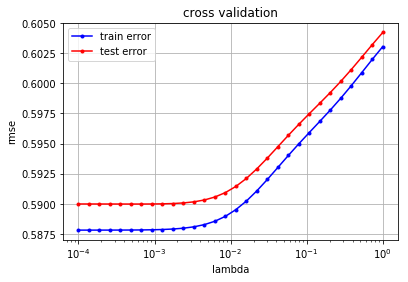

In [193]:
plt.semilogx(lambdas, rmse_tr, marker=".", color='b', label='train error')
plt.semilogx(lambdas, rmse_te, marker=".", color='r', label='test error')
plt.xlabel("lambda")
plt.ylabel("rmse")
plt.title("cross validation")
plt.legend(loc=2)
plt.grid(True)

In [194]:
np.argmin(rmse_te)

5

In [195]:
k_indices = build_k_indices(y, 2, 1)
y_test = y[k_indices[0]]    
x_test = x[k_indices[0]]

y_train = np.delete(y, k_indices[0], axis=0)
x_train = np.delete(x, k_indices[0], axis=0)
tx = build_poly(x_train, degree)

weights, mse = ridge_regression(y_train, tx, lambda_=0.0001)


In [196]:
weights

array([-8.06861342e-01, -6.26342166e-03, -6.73860066e-04,  1.02785403e-01,
       -1.25902542e-03,  4.22173838e-02,  1.38993152e-01,  3.03454374e-01,
        1.07385378e-02, -2.64824586e-02])

In [217]:
y_pred = predict_labels(weights, tx)
ones_aux = np.ones(len(y_pred))
correct = np.sum(ones_aux[np.equal(y_test, y_pred)])
incorrect = len(y_pred)-correct
perc = correct / len(y_pred) * 100
print("Total correct:", correct, "\nTotal incorrect:", incorrect, "\nCorrect percentage:", perc, "%")

print("-----------------------------")

rmse_train = np.sqrt(2*compute_mse(y_train, tx, weights))
rmse_test = np.sqrt(2*compute_mse(y_test, tx, weights))
print("Train RMSE:", rmse_train, ", Test RMSE:", rmse_test)


Total correct: 1463.0 
Total incorrect: 1037.0 
Correct percentage: 58.52 %
-----------------------------
Train RMSE: 0.8253568049700616 , Test RMSE: 1.0596008634494558
